## 数据和模型


<img src="data/logo.png" alt="Drawing" style="width: 300px;"/>

经过之前的一系列项目课程，我们已经接触了可以应用于不同的数据集来解决不同任务 (回归/分类) 的各种模型。后续的项目课程中，我们将会学习到更多不同的算法。
但其实我们忽略了一个有关数据和建模的根本问题: 质量和数量。简单地说，一个机器学习模型的工作方式就是接收输入，产出预测。训练数据的质量和数量，直接决定了预测的质量，也就是说: 垃圾数据产生垃圾结果。

<img src="data/nutshell.png" alt="Drawing" style="width: 500px;"/>


## 配置

我们在这儿会通过具体的代码示例介绍所有必要的概念。
首先我们还是制造一些用于训练的数据，这次的任务是根据白细胞的数量和血压预测肿瘤是良性还是恶性。

In [13]:
# 安装PyTorch
!pip install torch --upgrade -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Requirement already up-to-date: torch in d:\users\i9233\anaconda3\lib\site-packages (1.0.1)


In [45]:
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch

In [46]:
# 设置Numpy和pytorch随机种子
def set_seeds(seed, cuda):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

In [47]:
# 参数
args = Namespace(
    seed=1234,
    cuda=False,
    shuffle=True,
    data_file="data/tumors.csv",
    reduced_data_file="data/tumors_reduced.csv",
    train_size=0.75,
    test_size=0.25,
    num_hidden_units=100,
    learning_rate=1e-3,
    num_epochs=100,
)

# 设置种子
set_seeds(seed=args.seed, cuda=args.cuda)

# 检查是否有可用GPU
if torch.cuda.is_available():
    args.cuda = True
else:
    args.cuda = False

args.device = torch.device("cuda" if args.cuda else "cpu")

print("Using CUDA: {}".format(args.cuda))

Using CUDA: True


## 数据

In [48]:
import re
import urllib

In [49]:
# 下载数据
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file, 'wb') as fp:
    fp.write(html)

In [50]:
# 未处理过的数据
df = pd.read_csv(args.data_file, header=0)
df.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


In [20]:
def plot_tumors(df):
    i = 0; colors=['r', 'b']
    for name, group in df.groupby("tumor"):
        plt.scatter(group.leukocyte_count, group.blood_pressure, edgecolors='k',
                   color=colors[i]); i += 1
    plt.xlabel('leukocyte count')
    plt.ylabel('blood pressure')
    plt.legend(['0 - benign', '1 - malignant'], loc="upper right")
    plt.show()

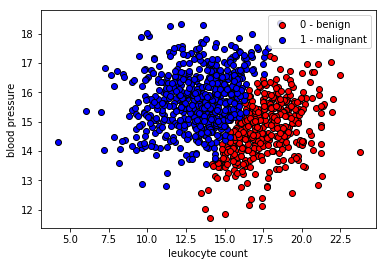

In [21]:
# 画图
plot_tumors(df)

In [22]:
# 转化为PyTorch Tensor
X = df.as_matrix(columns=['leukocyte_count', 'blood_pressure'])
y = df.as_matrix(columns=['tumor'])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

d:\Users\i9233\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Users\i9233\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [23]:
# 打乱数据
shuffle_indices = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indices]
y = y[shuffle_indices]

# 切分测试集和训练集
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 750 train samples and 250 test samples.


## 模型
用我们生成的数据训练模型。

In [24]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [25]:
# MLP 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [26]:
# 初始化模型
model = MLP(input_dim=len(df.columns)-1, 
            hidden_dim=args.num_hidden_units, 
            output_dim=len(set(df.tumor)))

In [27]:
# 优化
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) 

In [28]:
# 准确率
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [29]:
# 训练
for t in range(args.num_epochs):
    # 向前传播
    y_pred = model(X_train)
    
    # 准确率
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # 损失
    loss = loss_fn(y_pred, y_train)
    
    # 打印checkpoint
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # 梯度归零
    optimizer.zero_grad()

    # 反向传播
    loss.backward()

    # 更新权重
    optimizer.step()

epoch: 00 | loss: 4.5330 | accuracy: 38.8%
epoch: 20 | loss: 0.9263 | accuracy: 61.2%
epoch: 40 | loss: 0.3900 | accuracy: 94.5%
epoch: 60 | loss: 0.2852 | accuracy: 98.1%
epoch: 80 | loss: 0.1836 | accuracy: 98.1%


In [30]:
# 预测
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [31]:
# 训练集和测试集的准确率
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 98.9%, test acc: 98.8%


In [32]:
# 可视化
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())


我们来画一个白色的点，已知这个点对应的数据是一个恶性肿瘤。训练出的模型可以精确的预测它确实是一个恶性肿瘤。

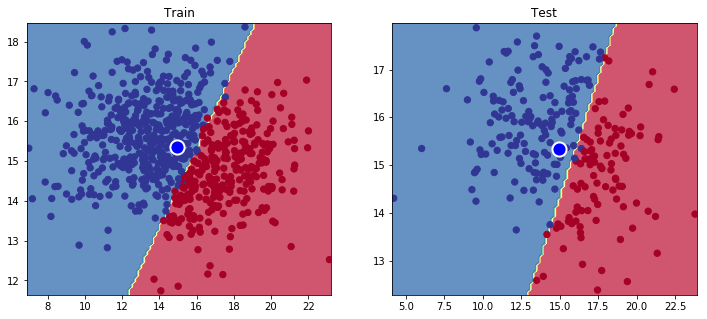

In [33]:
# 可视化决策边界
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.show()


真棒！模型的表现在测试集和训练集上都非常好，接下来我们将用这个数据集展示数据质量和数量的重要性

## 数据质量和数量

我们去掉决策边界附近的一些训练数据，然后观察模型的鲁棒性

In [34]:
# 加载数据
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/tumors_reduced.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.reduced_data_file, 'wb') as fp:
    fp.write(html)

In [35]:
# 未处理过的，去掉一些数据点的数据集
df_reduced = pd.read_csv(args.reduced_data_file, header=0)
df_reduced.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


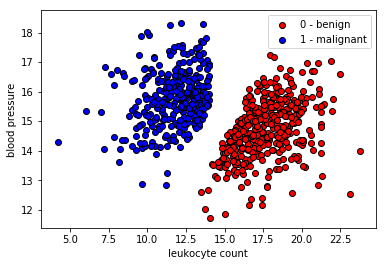

In [36]:
# 画图
plot_tumors(df_reduced)

In [37]:
# 转化为Pytorch Tensor
X = df_reduced.as_matrix(columns=['leukocyte_count', 'blood_pressure'])
y = df_reduced.as_matrix(columns=['tumor'])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()

d:\Users\i9233\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  
d:\Users\i9233\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  This is separate from the ipykernel package so we can avoid doing imports until


In [38]:
# 打乱数据
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# 切分训练集和测试集
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 540 train samples and 180 test samples.


In [39]:
# 初始化模型
model = MLP(input_dim=len(df_reduced.columns)-1, 
            hidden_dim=args.num_hidden_units, 
            output_dim=len(set(df_reduced.tumor)))

In [40]:
# 优化
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) 

In [41]:
# 训练
for t in range(args.num_epochs):
    # 向前传播
    y_pred = model(X_train)
    
    # 准确率
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # 损失
    loss = loss_fn(y_pred, y_train)
    
    # 打印checkpoint
    if t%20==0: 
        print ("epoch: {0} | loss: {1:.4f} | accuracy: {2:.1f}%".format(t, loss, accuracy))

    # 梯度归零
    optimizer.zero_grad()

    # 反向传播
    loss.backward()

    # 更新权重
    optimizer.step()

epoch: 0 | loss: 0.9148 | accuracy: 53.3%
epoch: 20 | loss: 0.2879 | accuracy: 100.0%
epoch: 40 | loss: 0.1336 | accuracy: 100.0%
epoch: 60 | loss: 0.0747 | accuracy: 100.0%
epoch: 80 | loss: 0.0505 | accuracy: 100.0%


In [42]:
# 预测
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [43]:
# 训练集和测试集的准确率
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 100.0%, test acc: 100.0%


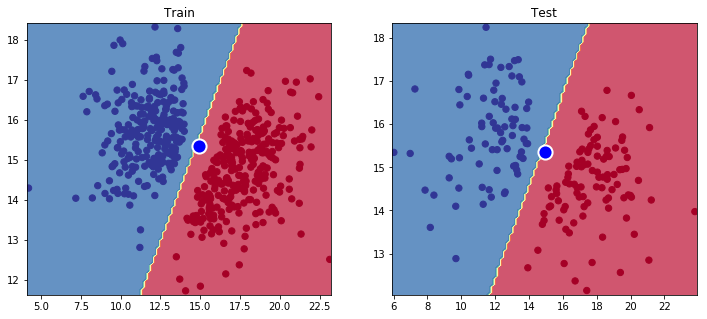

In [44]:
# 可视化决策边界
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.show()

这是一个可怕而又非常现实的情景。基于删减后的人造数据，我们依旧得到了一个在测试集上表现非常好的模型。但是，当我们我使用之前相同的白色的点（已知恶性肿瘤）对应的数据进行测试时，预测显示是一个良性肿瘤，模型出现了误判。

**模型不是水晶球**

在开始进行机器学习之前，需要记住的很重要一点是：我们需要审视数据，同时确定它确实是可以帮助我们解决问题的代表性数。如果数据质量很差，就算在训练集和测试集上的性能表现都非常好，这个模型依然是不可信的。

## 模型

一旦数据的质量和数量都得到了保证，你才可以开始考虑模型的选择和训练。模型的选择会取决于许多因素，包括进行的任务类型、数据类型、需求复杂度等。


<img src="data/models1.png" alt="Drawing" style="width: 600px;"/>


一旦弄清了该任务需要的模型时，我们建议从简单的模型开始，逐渐增加复杂度。你一定不会想从一个复杂的神经网络开始工作，因为那可能并不是和你手上的数据和要解决的问题相匹配的模型。平衡模型的复杂度是你数据科学家的关键任务。**简单模型 → 复杂模型**